# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
176/32
32*5


160

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

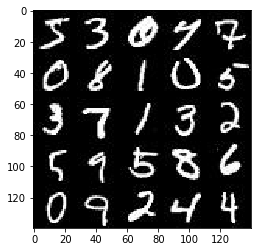

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

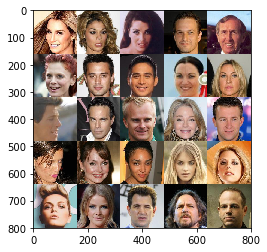

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 160, 160, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\egork\\Anaconda3\\envs\\aind\\lib\\site-packages\\ipykernel\\kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "C:\\Users\\eg

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    drop_rate = 0.05
    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        filters = 64
        # Input layer is 28x28x3
        x = tf.layers.conv2d(inputs = x, 
                     filters = filters, 
                     kernel_size = 5, 
                     strides = 1,
                     padding="same")
        x = tf.concat([images,tf.contrib.keras.layers.LeakyReLU(alpha)(x)],3)
        x = tf.layers.dropout(x, drop_rate, training = True)
        for i in range(3):
            x = tf.layers.conv2d(inputs = x, 
                                 filters = filters, 
                                 kernel_size = 5, 
                                 strides = 2,
                                 padding="same")
            #x = tf.layers.batch_normalization(x, training = True)
            x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
            x = tf.layers.dropout(x, drop_rate, training = True)
            filters = 2*filters
        #print(x.get_shape().as_list())
        flat = tf.contrib.layers.flatten(x)
        logits = tf.layers.dense(flat,1)
        #out = tf.sigmoid(logits)
        
        return logits

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    # Why on earth does the test check for the number of args?
    alpha = 0.2
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    drop_rate = 0.5
    init_dim =[-1,7,7,512]
    init_len = 7*7*512
    filters = 512
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer
        x = tf.layers.dense(z,init_len)
        x = tf.reshape(x, tf.cast(init_dim, tf.int32))
        x = tf.layers.batch_normalization(x, training = is_train)
        x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
        x = tf.layers.dropout(x, drop_rate, training = is_train)
        # so now we're at 7x7x512
        for i in range(2):
            filters = filters/2
            x = tf.layers.conv2d_transpose(inputs = x, 
                                           filters = int(filters), 
                                           kernel_size =5,
                                           strides = 2,
                                           padding = 'same')

            x = tf.layers.batch_normalization(x, training = is_train)
            x = tf.contrib.keras.layers.LeakyReLU(alpha)(x)
            x = tf.layers.dropout(x, drop_rate, training = is_train)
        
        x = tf.layers.conv2d_transpose(inputs = x, 
                                   filters = out_channel_dim, 
                                   kernel_size = 5,
                                   strides = 1,
                                   padding = 'same')
        # Output layer, 28x28x3 
        # rather than mess around with convolutions to get the size just right, let's just trim it
        #logits = tf.slice(x, [0,0,0,0],[-1,28,28,-1])
        logits = x
        out = 0.5*tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, batch_size, alpha=0.2, lmbda = 10):
    
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    input_fake = generator(input_z, out_channel_dim)
    d_real = discriminator(input_real, alpha=alpha)
    d_fake = discriminator(input_fake, reuse=True, alpha=alpha)
    
    alpha2 = tf.random_uniform(shape=[batch_size,1,1,1], minval=0.,maxval=1.)
    
    #TODO: does this work correctly with broadcasting?
    interpolates = alpha2*input_real + ((1-alpha2)*input_fake)
    disc_interpolates = discriminator(interpolates, reuse=True, alpha=alpha)
    gradients = tf.gradients(disc_interpolates, interpolates)[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1,2,3]))
    gradient_penalty = tf.reduce_mean((slopes-1)**2)
    
    d_loss = -(tf.reduce_mean(d_real) - tf.reduce_mean(d_fake))
    d_loss += lmbda*gradient_penalty
    
    g_loss = -tf.reduce_mean(d_fake)

    return d_loss, g_loss


# """
# DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
# """
# tests.test_model_loss(model_loss)

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=0.9).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=0.9).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    critic_iter= 5
    
    dummy, image_width, image_height, out_channel_dim =  data_shape
    input_real, input_z, learning_rate_ph = model_inputs(image_width, image_height, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim, batch_size)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
                
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                for _ in range(critic_iter):
                    _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1,epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z,out_channel_dim, is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess,9, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
    import pickle
    with open('samples.pkl', 'wb') as f:
        pickle.dump(samples, f)
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: -8.0276... Generator Loss: 0.4615
Epoch 1/2... Discriminator Loss: -6.9255... Generator Loss: 2.6066
Epoch 1/2... Discriminator Loss: -5.9837... Generator Loss: 3.6936
Epoch 1/2... Discriminator Loss: -4.5797... Generator Loss: 2.0314
Epoch 1/2... Discriminator Loss: -3.5090... Generator Loss: 2.8282
Epoch 1/2... Discriminator Loss: -3.1333... Generator Loss: 2.3047
Epoch 1/2... Discriminator Loss: -2.3135... Generator Loss: 3.0494
Epoch 1/2... Discriminator Loss: -2.4668... Generator Loss: 2.8920
Epoch 1/2... Discriminator Loss: -2.5506... Generator Loss: 3.0261
Epoch 1/2... Discriminator Loss: -2.7539... Generator Loss: 4.1769


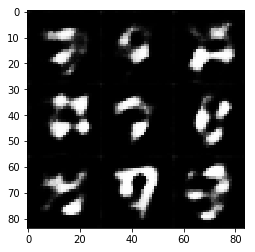

Epoch 1/2... Discriminator Loss: -2.7871... Generator Loss: 4.6620
Epoch 1/2... Discriminator Loss: -2.5752... Generator Loss: 4.2079
Epoch 1/2... Discriminator Loss: -2.5378... Generator Loss: 3.8641
Epoch 1/2... Discriminator Loss: -2.4713... Generator Loss: 3.8440
Epoch 1/2... Discriminator Loss: -3.1432... Generator Loss: 4.8853
Epoch 1/2... Discriminator Loss: -2.5432... Generator Loss: 4.6796
Epoch 1/2... Discriminator Loss: -2.8009... Generator Loss: 4.8563
Epoch 1/2... Discriminator Loss: -2.5976... Generator Loss: 5.3644
Epoch 1/2... Discriminator Loss: -2.8110... Generator Loss: 5.8740
Epoch 1/2... Discriminator Loss: -2.8989... Generator Loss: 4.8216


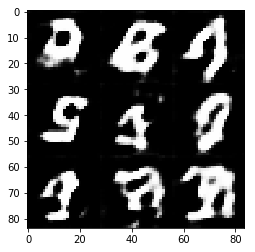

Epoch 1/2... Discriminator Loss: -3.9915... Generator Loss: 5.2452
Epoch 1/2... Discriminator Loss: -2.6881... Generator Loss: 4.0132
Epoch 1/2... Discriminator Loss: -2.7618... Generator Loss: 5.5298
Epoch 1/2... Discriminator Loss: -2.9731... Generator Loss: 4.7540
Epoch 1/2... Discriminator Loss: -3.0120... Generator Loss: 4.8291
Epoch 1/2... Discriminator Loss: -2.5010... Generator Loss: 4.2766
Epoch 1/2... Discriminator Loss: -2.7870... Generator Loss: 3.3854
Epoch 1/2... Discriminator Loss: -2.4151... Generator Loss: 3.7061
Epoch 1/2... Discriminator Loss: -2.3039... Generator Loss: 3.8658
Epoch 1/2... Discriminator Loss: -2.9947... Generator Loss: 4.2057


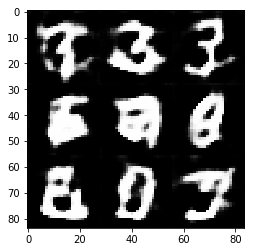

Epoch 1/2... Discriminator Loss: -3.0266... Generator Loss: 5.0996
Epoch 1/2... Discriminator Loss: -2.4597... Generator Loss: 3.7967
Epoch 1/2... Discriminator Loss: -3.1282... Generator Loss: 5.3744
Epoch 1/2... Discriminator Loss: -3.1454... Generator Loss: 3.6676
Epoch 1/2... Discriminator Loss: -3.0621... Generator Loss: 4.3119
Epoch 1/2... Discriminator Loss: -2.5335... Generator Loss: 3.7907
Epoch 1/2... Discriminator Loss: -2.7468... Generator Loss: 3.4774
Epoch 1/2... Discriminator Loss: -2.8365... Generator Loss: 2.7039
Epoch 1/2... Discriminator Loss: -2.5110... Generator Loss: 2.5207
Epoch 1/2... Discriminator Loss: -2.0731... Generator Loss: 3.7297


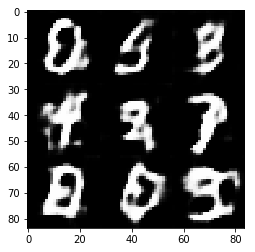

Epoch 1/2... Discriminator Loss: -2.2525... Generator Loss: 3.1006
Epoch 1/2... Discriminator Loss: -2.2885... Generator Loss: 4.3062
Epoch 1/2... Discriminator Loss: -2.5328... Generator Loss: 1.7628
Epoch 1/2... Discriminator Loss: -2.3264... Generator Loss: 2.7508
Epoch 1/2... Discriminator Loss: -2.9963... Generator Loss: 1.5379
Epoch 1/2... Discriminator Loss: -2.3534... Generator Loss: 0.4591
Epoch 1/2... Discriminator Loss: -2.0220... Generator Loss: -0.6385
Epoch 1/2... Discriminator Loss: -2.5336... Generator Loss: 2.4406
Epoch 1/2... Discriminator Loss: -2.0768... Generator Loss: 1.5380
Epoch 1/2... Discriminator Loss: -2.1491... Generator Loss: 0.3853


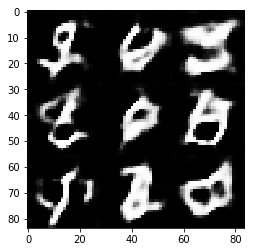

Epoch 1/2... Discriminator Loss: -2.1379... Generator Loss: -1.7093
Epoch 1/2... Discriminator Loss: -2.3329... Generator Loss: 3.3801
Epoch 1/2... Discriminator Loss: -2.0258... Generator Loss: 1.2376
Epoch 1/2... Discriminator Loss: -2.2930... Generator Loss: 0.7003
Epoch 1/2... Discriminator Loss: -2.0677... Generator Loss: -2.3545
Epoch 1/2... Discriminator Loss: -1.7840... Generator Loss: -1.7177
Epoch 1/2... Discriminator Loss: -1.5608... Generator Loss: -0.7224
Epoch 1/2... Discriminator Loss: -1.9744... Generator Loss: 0.5950
Epoch 1/2... Discriminator Loss: -1.8053... Generator Loss: -0.8870
Epoch 1/2... Discriminator Loss: -2.4035... Generator Loss: 0.0773


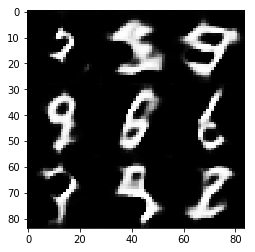

Epoch 1/2... Discriminator Loss: -1.9876... Generator Loss: -1.4956
Epoch 1/2... Discriminator Loss: -2.1013... Generator Loss: -2.6134
Epoch 1/2... Discriminator Loss: -2.0357... Generator Loss: 0.3064
Epoch 1/2... Discriminator Loss: -2.3726... Generator Loss: -0.4797
Epoch 1/2... Discriminator Loss: -1.9696... Generator Loss: -0.7136
Epoch 1/2... Discriminator Loss: -1.7530... Generator Loss: -1.6697
Epoch 1/2... Discriminator Loss: -2.1140... Generator Loss: 1.9680
Epoch 1/2... Discriminator Loss: -1.9283... Generator Loss: 2.7874
Epoch 1/2... Discriminator Loss: -1.8276... Generator Loss: -1.4083
Epoch 1/2... Discriminator Loss: -1.9910... Generator Loss: -0.2093


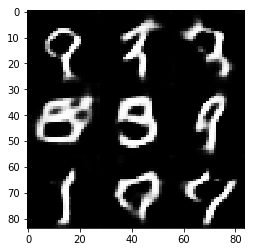

Epoch 1/2... Discriminator Loss: -2.2240... Generator Loss: -4.2460
Epoch 1/2... Discriminator Loss: -1.9285... Generator Loss: -0.9073
Epoch 1/2... Discriminator Loss: -2.0197... Generator Loss: 0.1141
Epoch 1/2... Discriminator Loss: -2.2517... Generator Loss: 0.0170
Epoch 1/2... Discriminator Loss: -1.8532... Generator Loss: -2.4955
Epoch 1/2... Discriminator Loss: -1.8927... Generator Loss: -0.7018
Epoch 1/2... Discriminator Loss: -1.9128... Generator Loss: -0.7089
Epoch 1/2... Discriminator Loss: -2.5685... Generator Loss: -2.1579
Epoch 1/2... Discriminator Loss: -2.0159... Generator Loss: -0.9565
Epoch 1/2... Discriminator Loss: -1.8774... Generator Loss: 0.4852


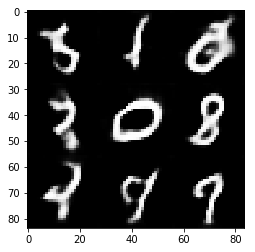

Epoch 1/2... Discriminator Loss: -1.9626... Generator Loss: 1.1530
Epoch 1/2... Discriminator Loss: -2.0876... Generator Loss: 1.5803
Epoch 1/2... Discriminator Loss: -1.5323... Generator Loss: 0.0959
Epoch 1/2... Discriminator Loss: -2.6920... Generator Loss: -1.0998
Epoch 1/2... Discriminator Loss: -2.3688... Generator Loss: 4.4621
Epoch 1/2... Discriminator Loss: -1.2242... Generator Loss: 2.2940
Epoch 1/2... Discriminator Loss: -1.5438... Generator Loss: 0.5578
Epoch 1/2... Discriminator Loss: -1.6193... Generator Loss: 0.9849
Epoch 1/2... Discriminator Loss: -2.1683... Generator Loss: -0.3191
Epoch 1/2... Discriminator Loss: -1.8109... Generator Loss: -0.4945


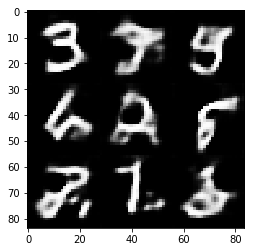

Epoch 1/2... Discriminator Loss: -1.6947... Generator Loss: 0.0796
Epoch 1/2... Discriminator Loss: -1.5840... Generator Loss: -1.0022
Epoch 1/2... Discriminator Loss: -1.5125... Generator Loss: 1.6272
Epoch 2/2... Discriminator Loss: -2.4902... Generator Loss: -0.9557
Epoch 2/2... Discriminator Loss: -1.5261... Generator Loss: -0.4442
Epoch 2/2... Discriminator Loss: -1.7273... Generator Loss: -0.5686
Epoch 2/2... Discriminator Loss: -1.5643... Generator Loss: -0.6690
Epoch 2/2... Discriminator Loss: -1.5885... Generator Loss: 2.4188
Epoch 2/2... Discriminator Loss: -1.5759... Generator Loss: -0.4967
Epoch 2/2... Discriminator Loss: -1.8763... Generator Loss: 1.5513


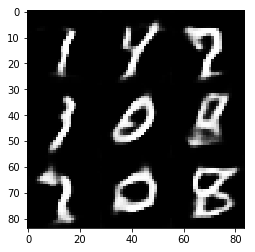

Epoch 2/2... Discriminator Loss: -2.1462... Generator Loss: 1.0081
Epoch 2/2... Discriminator Loss: -2.5430... Generator Loss: 0.9136
Epoch 2/2... Discriminator Loss: -2.2430... Generator Loss: 1.2250
Epoch 2/2... Discriminator Loss: -1.9971... Generator Loss: 1.0687
Epoch 2/2... Discriminator Loss: -1.9287... Generator Loss: 0.5841
Epoch 2/2... Discriminator Loss: -1.6908... Generator Loss: -0.7797
Epoch 2/2... Discriminator Loss: -1.5956... Generator Loss: 1.7620
Epoch 2/2... Discriminator Loss: -1.7131... Generator Loss: -1.1191
Epoch 2/2... Discriminator Loss: -1.5439... Generator Loss: 1.7796
Epoch 2/2... Discriminator Loss: -1.5779... Generator Loss: 1.2459


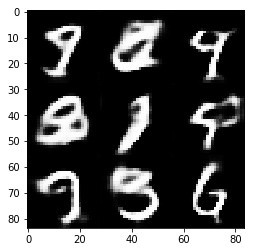

Epoch 2/2... Discriminator Loss: -2.9825... Generator Loss: 1.1160
Epoch 2/2... Discriminator Loss: -2.0611... Generator Loss: -0.2271
Epoch 2/2... Discriminator Loss: -1.5351... Generator Loss: 1.1766
Epoch 2/2... Discriminator Loss: -1.3664... Generator Loss: -0.7798
Epoch 2/2... Discriminator Loss: -1.1446... Generator Loss: 0.9725
Epoch 2/2... Discriminator Loss: -2.1786... Generator Loss: 1.1317
Epoch 2/2... Discriminator Loss: -2.2601... Generator Loss: 1.0050
Epoch 2/2... Discriminator Loss: -1.4482... Generator Loss: 2.9885
Epoch 2/2... Discriminator Loss: -1.7987... Generator Loss: 2.2867
Epoch 2/2... Discriminator Loss: -1.8795... Generator Loss: 0.7643


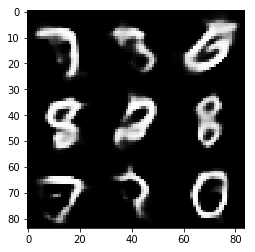

Epoch 2/2... Discriminator Loss: -1.8013... Generator Loss: -0.3620
Epoch 2/2... Discriminator Loss: -1.8235... Generator Loss: -0.1338
Epoch 2/2... Discriminator Loss: -2.2631... Generator Loss: 2.3234
Epoch 2/2... Discriminator Loss: -2.1200... Generator Loss: 4.2618
Epoch 2/2... Discriminator Loss: -1.3353... Generator Loss: 0.9257
Epoch 2/2... Discriminator Loss: -1.8532... Generator Loss: -0.2975
Epoch 2/2... Discriminator Loss: -1.5826... Generator Loss: 1.6830
Epoch 2/2... Discriminator Loss: -1.7672... Generator Loss: 1.5813
Epoch 2/2... Discriminator Loss: -2.7926... Generator Loss: 4.9850
Epoch 2/2... Discriminator Loss: -2.0035... Generator Loss: 1.9593


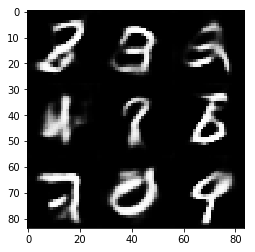

Epoch 2/2... Discriminator Loss: -1.7393... Generator Loss: 1.2995
Epoch 2/2... Discriminator Loss: -1.2429... Generator Loss: 1.5069
Epoch 2/2... Discriminator Loss: -1.6075... Generator Loss: 1.5468
Epoch 2/2... Discriminator Loss: -1.5310... Generator Loss: 1.1645
Epoch 2/2... Discriminator Loss: -1.8319... Generator Loss: 1.0690
Epoch 2/2... Discriminator Loss: -2.5690... Generator Loss: 3.0949
Epoch 2/2... Discriminator Loss: -1.8435... Generator Loss: 1.3023
Epoch 2/2... Discriminator Loss: -1.6420... Generator Loss: 2.9068
Epoch 2/2... Discriminator Loss: -1.4848... Generator Loss: 2.7040
Epoch 2/2... Discriminator Loss: -2.1444... Generator Loss: -0.7309


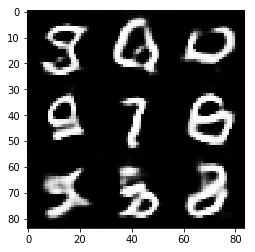

Epoch 2/2... Discriminator Loss: -1.8974... Generator Loss: 0.2225
Epoch 2/2... Discriminator Loss: -2.3520... Generator Loss: 2.9884
Epoch 2/2... Discriminator Loss: -1.3349... Generator Loss: 2.9268
Epoch 2/2... Discriminator Loss: -2.2272... Generator Loss: 4.2544
Epoch 2/2... Discriminator Loss: -1.7366... Generator Loss: 0.3589
Epoch 2/2... Discriminator Loss: -1.6836... Generator Loss: 2.9257
Epoch 2/2... Discriminator Loss: -1.4541... Generator Loss: 3.3125
Epoch 2/2... Discriminator Loss: -1.5299... Generator Loss: 2.2126
Epoch 2/2... Discriminator Loss: -1.7899... Generator Loss: 1.8869
Epoch 2/2... Discriminator Loss: -2.3516... Generator Loss: 1.7405


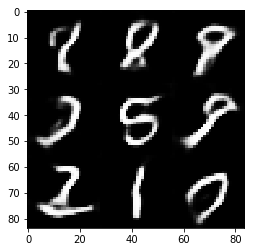

Epoch 2/2... Discriminator Loss: -2.1706... Generator Loss: 4.2483
Epoch 2/2... Discriminator Loss: -2.1701... Generator Loss: 4.2813
Epoch 2/2... Discriminator Loss: -2.3802... Generator Loss: 3.5652
Epoch 2/2... Discriminator Loss: -2.0218... Generator Loss: 3.4467
Epoch 2/2... Discriminator Loss: -2.3707... Generator Loss: 3.2535
Epoch 2/2... Discriminator Loss: -1.4564... Generator Loss: 1.1995
Epoch 2/2... Discriminator Loss: -1.5081... Generator Loss: 2.9080
Epoch 2/2... Discriminator Loss: -2.1625... Generator Loss: 1.6890
Epoch 2/2... Discriminator Loss: -1.2225... Generator Loss: 2.1514
Epoch 2/2... Discriminator Loss: -1.6391... Generator Loss: 1.3026


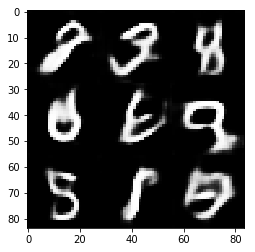

Epoch 2/2... Discriminator Loss: -1.5436... Generator Loss: 2.3369
Epoch 2/2... Discriminator Loss: -2.0278... Generator Loss: 3.4156
Epoch 2/2... Discriminator Loss: -2.1658... Generator Loss: 3.6070
Epoch 2/2... Discriminator Loss: -1.7996... Generator Loss: 2.6732
Epoch 2/2... Discriminator Loss: -1.7247... Generator Loss: 0.8904
Epoch 2/2... Discriminator Loss: -1.8913... Generator Loss: 2.4234
Epoch 2/2... Discriminator Loss: -1.6369... Generator Loss: 1.9090
Epoch 2/2... Discriminator Loss: -1.5901... Generator Loss: 1.2484
Epoch 2/2... Discriminator Loss: -1.8550... Generator Loss: 3.1961
Epoch 2/2... Discriminator Loss: -2.0079... Generator Loss: 1.8431


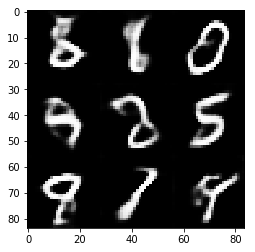

Epoch 2/2... Discriminator Loss: -1.9899... Generator Loss: 1.5616
Epoch 2/2... Discriminator Loss: -1.3996... Generator Loss: 2.1567
Epoch 2/2... Discriminator Loss: -1.7012... Generator Loss: 2.5018
Epoch 2/2... Discriminator Loss: -1.7437... Generator Loss: 2.4457
Epoch 2/2... Discriminator Loss: -1.9751... Generator Loss: 3.6328
Epoch 2/2... Discriminator Loss: -2.1314... Generator Loss: 3.4093
Epoch 2/2... Discriminator Loss: -2.0210... Generator Loss: 4.1524
Epoch 2/2... Discriminator Loss: -2.1637... Generator Loss: 3.1909
Epoch 2/2... Discriminator Loss: -2.5090... Generator Loss: 4.2652
Epoch 2/2... Discriminator Loss: -1.3812... Generator Loss: 7.1230


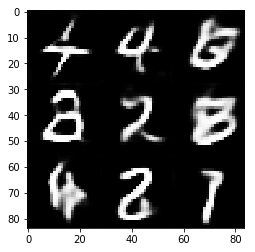

Epoch 2/2... Discriminator Loss: -1.5586... Generator Loss: 2.0552
Epoch 2/2... Discriminator Loss: -1.5173... Generator Loss: 3.2247
Epoch 2/2... Discriminator Loss: -1.2696... Generator Loss: 2.6138
Epoch 2/2... Discriminator Loss: -1.7653... Generator Loss: 2.0110
Epoch 2/2... Discriminator Loss: -1.6089... Generator Loss: 1.6377
Epoch 2/2... Discriminator Loss: -1.4264... Generator Loss: 4.0550
Epoch 2/2... Discriminator Loss: -2.0440... Generator Loss: 2.8664


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
print_every = 10
show_every= 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: -15.9309... Generator Loss: 20.3248
Epoch 1/2... Discriminator Loss: -18.3988... Generator Loss: 25.4198
Epoch 1/2... Discriminator Loss: -18.9551... Generator Loss: 27.0235
Epoch 1/2... Discriminator Loss: -16.4996... Generator Loss: 22.8111
Epoch 1/2... Discriminator Loss: -11.8438... Generator Loss: 25.6146
Epoch 1/2... Discriminator Loss: -10.2397... Generator Loss: 25.2475
Epoch 1/2... Discriminator Loss: -9.8778... Generator Loss: 25.8158
Epoch 1/2... Discriminator Loss: -9.0902... Generator Loss: 20.9987
Epoch 1/2... Discriminator Loss: -8.7256... Generator Loss: 23.1637
Epoch 1/2... Discriminator Loss: -7.9482... Generator Loss: 19.1912


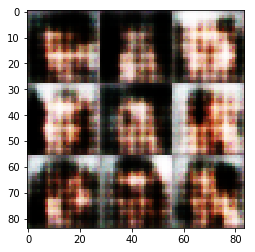

Epoch 1/2... Discriminator Loss: -7.4291... Generator Loss: 19.2771
Epoch 1/2... Discriminator Loss: -7.2514... Generator Loss: 17.6059
Epoch 1/2... Discriminator Loss: -6.9843... Generator Loss: 14.7531
Epoch 1/2... Discriminator Loss: -6.4517... Generator Loss: 14.1464
Epoch 1/2... Discriminator Loss: -6.3082... Generator Loss: 14.4461
Epoch 1/2... Discriminator Loss: -6.0631... Generator Loss: 14.8684
Epoch 1/2... Discriminator Loss: -5.6817... Generator Loss: 12.8133
Epoch 1/2... Discriminator Loss: -5.5668... Generator Loss: 13.1429
Epoch 1/2... Discriminator Loss: -5.4267... Generator Loss: 12.6971
Epoch 1/2... Discriminator Loss: -5.1535... Generator Loss: 13.7825


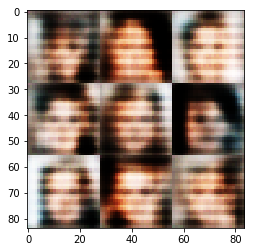

Epoch 1/2... Discriminator Loss: -4.7383... Generator Loss: 14.0017
Epoch 1/2... Discriminator Loss: -4.7091... Generator Loss: 12.1199
Epoch 1/2... Discriminator Loss: -4.7657... Generator Loss: 10.8439
Epoch 1/2... Discriminator Loss: -4.4210... Generator Loss: 13.0207
Epoch 1/2... Discriminator Loss: -4.2439... Generator Loss: 11.5624
Epoch 1/2... Discriminator Loss: -4.1681... Generator Loss: 9.2426
Epoch 1/2... Discriminator Loss: -4.2873... Generator Loss: 11.0577
Epoch 1/2... Discriminator Loss: -3.3208... Generator Loss: 7.5376
Epoch 1/2... Discriminator Loss: -3.3147... Generator Loss: 7.9633
Epoch 1/2... Discriminator Loss: -3.1687... Generator Loss: 6.8323


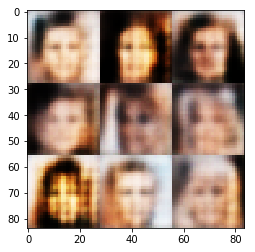

Epoch 1/2... Discriminator Loss: -2.4016... Generator Loss: 7.6113
Epoch 1/2... Discriminator Loss: -2.6580... Generator Loss: 7.9296
Epoch 1/2... Discriminator Loss: -2.8903... Generator Loss: 6.5277
Epoch 1/2... Discriminator Loss: -2.4466... Generator Loss: 5.0454
Epoch 1/2... Discriminator Loss: -2.3429... Generator Loss: 8.5416
Epoch 1/2... Discriminator Loss: -2.8028... Generator Loss: 4.3490
Epoch 1/2... Discriminator Loss: -2.4159... Generator Loss: 5.1917
Epoch 1/2... Discriminator Loss: -2.8231... Generator Loss: 3.7222
Epoch 1/2... Discriminator Loss: -2.5850... Generator Loss: 4.0850
Epoch 1/2... Discriminator Loss: -2.6853... Generator Loss: 5.0683


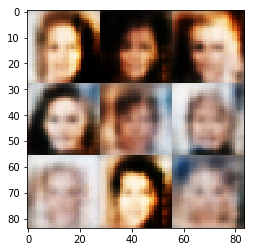

Epoch 1/2... Discriminator Loss: -2.3274... Generator Loss: 7.0926
Epoch 1/2... Discriminator Loss: -2.2463... Generator Loss: 5.8594
Epoch 1/2... Discriminator Loss: -1.9063... Generator Loss: 5.5128
Epoch 1/2... Discriminator Loss: -2.5456... Generator Loss: 6.4665
Epoch 1/2... Discriminator Loss: -1.7865... Generator Loss: 3.0399
Epoch 1/2... Discriminator Loss: -2.2127... Generator Loss: -1.2072
Epoch 1/2... Discriminator Loss: -2.2516... Generator Loss: 6.1564
Epoch 1/2... Discriminator Loss: -2.0227... Generator Loss: 2.5997
Epoch 1/2... Discriminator Loss: -2.1049... Generator Loss: 2.6699
Epoch 1/2... Discriminator Loss: -2.0624... Generator Loss: 3.8972


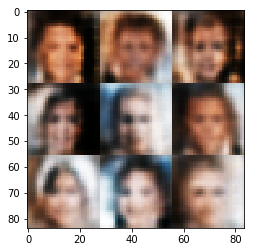

Epoch 1/2... Discriminator Loss: -2.1923... Generator Loss: 3.3403
Epoch 1/2... Discriminator Loss: -2.0530... Generator Loss: 5.5657
Epoch 1/2... Discriminator Loss: -1.8228... Generator Loss: 5.3472
Epoch 1/2... Discriminator Loss: -1.6757... Generator Loss: 5.1523
Epoch 1/2... Discriminator Loss: -1.8186... Generator Loss: 5.4912
Epoch 1/2... Discriminator Loss: -1.8812... Generator Loss: 5.6417
Epoch 1/2... Discriminator Loss: -1.7435... Generator Loss: 4.6870
Epoch 1/2... Discriminator Loss: -1.8534... Generator Loss: 2.9622
Epoch 1/2... Discriminator Loss: -1.8818... Generator Loss: -0.6135
Epoch 1/2... Discriminator Loss: -1.9219... Generator Loss: 5.8582


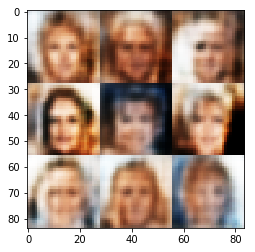

Epoch 1/2... Discriminator Loss: -1.5122... Generator Loss: 5.8163
Epoch 1/2... Discriminator Loss: -1.5780... Generator Loss: 0.7483
Epoch 1/2... Discriminator Loss: -1.7995... Generator Loss: 2.7804
Epoch 1/2... Discriminator Loss: -1.2173... Generator Loss: 5.0714
Epoch 1/2... Discriminator Loss: -2.0303... Generator Loss: 3.8916
Epoch 1/2... Discriminator Loss: -1.9003... Generator Loss: -1.5767
Epoch 1/2... Discriminator Loss: -1.3118... Generator Loss: 1.6018
Epoch 1/2... Discriminator Loss: -1.6396... Generator Loss: 3.7923
Epoch 1/2... Discriminator Loss: -1.4797... Generator Loss: 10.3414
Epoch 1/2... Discriminator Loss: -1.7285... Generator Loss: 8.0269


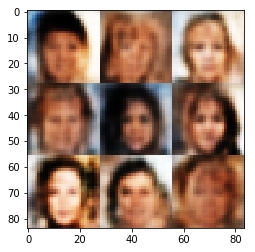

Epoch 1/2... Discriminator Loss: -1.7823... Generator Loss: -3.5772
Epoch 1/2... Discriminator Loss: -1.4837... Generator Loss: 1.8194
Epoch 1/2... Discriminator Loss: -1.8232... Generator Loss: 6.9628
Epoch 1/2... Discriminator Loss: -1.4513... Generator Loss: 9.1356
Epoch 1/2... Discriminator Loss: -1.6266... Generator Loss: 8.6614
Epoch 1/2... Discriminator Loss: -1.8628... Generator Loss: 7.6358
Epoch 1/2... Discriminator Loss: -1.5706... Generator Loss: 9.6650
Epoch 1/2... Discriminator Loss: -1.4068... Generator Loss: 10.0123
Epoch 1/2... Discriminator Loss: -2.2352... Generator Loss: 11.3246
Epoch 1/2... Discriminator Loss: -1.4210... Generator Loss: 5.5583


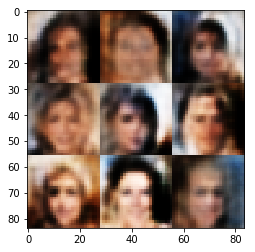

Epoch 1/2... Discriminator Loss: -1.6408... Generator Loss: 7.9396
Epoch 1/2... Discriminator Loss: -1.4188... Generator Loss: 8.1110
Epoch 1/2... Discriminator Loss: -1.5727... Generator Loss: 9.2036
Epoch 1/2... Discriminator Loss: -1.8516... Generator Loss: 6.5532
Epoch 1/2... Discriminator Loss: -1.6363... Generator Loss: 10.4249
Epoch 1/2... Discriminator Loss: -1.7511... Generator Loss: 10.1594
Epoch 1/2... Discriminator Loss: -1.5932... Generator Loss: 8.3475
Epoch 1/2... Discriminator Loss: -1.3812... Generator Loss: 7.6278
Epoch 1/2... Discriminator Loss: -1.3902... Generator Loss: 5.8315
Epoch 1/2... Discriminator Loss: -1.5942... Generator Loss: 8.7385


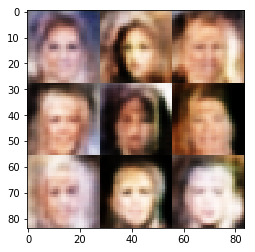

Epoch 1/2... Discriminator Loss: -1.3976... Generator Loss: 7.6507
Epoch 1/2... Discriminator Loss: -1.7269... Generator Loss: 8.5371
Epoch 1/2... Discriminator Loss: -1.2797... Generator Loss: 7.7264
Epoch 1/2... Discriminator Loss: -1.4277... Generator Loss: 5.6796
Epoch 1/2... Discriminator Loss: -1.1676... Generator Loss: 6.1739
Epoch 1/2... Discriminator Loss: -1.0295... Generator Loss: 5.9535
Epoch 1/2... Discriminator Loss: -1.3167... Generator Loss: 7.1576
Epoch 1/2... Discriminator Loss: -1.1067... Generator Loss: 4.4940
Epoch 1/2... Discriminator Loss: -0.9810... Generator Loss: 3.0078
Epoch 1/2... Discriminator Loss: -1.4097... Generator Loss: 0.1455


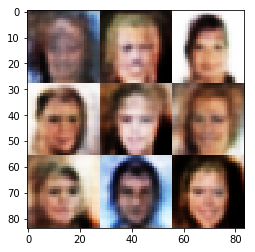

Epoch 1/2... Discriminator Loss: -1.5910... Generator Loss: 5.1650
Epoch 1/2... Discriminator Loss: -1.4157... Generator Loss: 7.0277
Epoch 1/2... Discriminator Loss: -1.2848... Generator Loss: 5.0525
Epoch 1/2... Discriminator Loss: -1.1894... Generator Loss: 4.7491
Epoch 1/2... Discriminator Loss: -1.2057... Generator Loss: 5.6494
Epoch 1/2... Discriminator Loss: -1.4489... Generator Loss: 7.3542
Epoch 1/2... Discriminator Loss: -1.5525... Generator Loss: 5.1967
Epoch 1/2... Discriminator Loss: -1.4251... Generator Loss: 5.7998
Epoch 1/2... Discriminator Loss: -1.3470... Generator Loss: 7.7860
Epoch 1/2... Discriminator Loss: -1.1246... Generator Loss: 8.2034


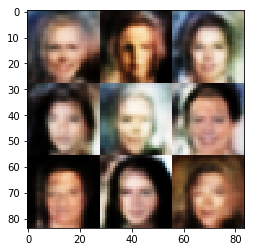

Epoch 1/2... Discriminator Loss: -1.6081... Generator Loss: 7.2794
Epoch 1/2... Discriminator Loss: -1.3842... Generator Loss: 7.2804
Epoch 1/2... Discriminator Loss: -1.5784... Generator Loss: 4.5776
Epoch 1/2... Discriminator Loss: -1.3691... Generator Loss: 6.5800
Epoch 1/2... Discriminator Loss: -1.3863... Generator Loss: 5.1329
Epoch 1/2... Discriminator Loss: -1.4962... Generator Loss: 5.8892
Epoch 1/2... Discriminator Loss: -1.7826... Generator Loss: 9.4855
Epoch 1/2... Discriminator Loss: -1.2696... Generator Loss: 4.6964
Epoch 1/2... Discriminator Loss: -1.4388... Generator Loss: 5.1158
Epoch 1/2... Discriminator Loss: -1.5119... Generator Loss: 4.7089


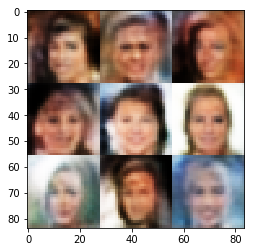

Epoch 1/2... Discriminator Loss: -1.5337... Generator Loss: 7.1588
Epoch 1/2... Discriminator Loss: -1.6098... Generator Loss: 8.3676
Epoch 1/2... Discriminator Loss: -1.5635... Generator Loss: 7.2431
Epoch 1/2... Discriminator Loss: -1.3323... Generator Loss: 5.3158
Epoch 1/2... Discriminator Loss: -1.7534... Generator Loss: 3.8510
Epoch 1/2... Discriminator Loss: -1.5421... Generator Loss: 6.7210
Epoch 1/2... Discriminator Loss: -1.2328... Generator Loss: 6.7319
Epoch 1/2... Discriminator Loss: -1.0586... Generator Loss: 3.2781
Epoch 1/2... Discriminator Loss: -1.3250... Generator Loss: 3.7168
Epoch 1/2... Discriminator Loss: -1.2476... Generator Loss: 1.9102


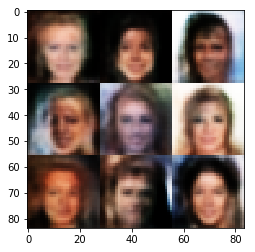

Epoch 1/2... Discriminator Loss: -1.1657... Generator Loss: 2.1736
Epoch 1/2... Discriminator Loss: -1.3810... Generator Loss: 3.1027
Epoch 1/2... Discriminator Loss: -1.4960... Generator Loss: 6.2680
Epoch 1/2... Discriminator Loss: -1.8031... Generator Loss: 9.7552
Epoch 1/2... Discriminator Loss: -1.5205... Generator Loss: 1.9918
Epoch 1/2... Discriminator Loss: -1.3903... Generator Loss: 2.0193
Epoch 1/2... Discriminator Loss: -1.4133... Generator Loss: 6.3158
Epoch 1/2... Discriminator Loss: -1.2482... Generator Loss: 3.9709
Epoch 1/2... Discriminator Loss: -1.6183... Generator Loss: 7.8110
Epoch 1/2... Discriminator Loss: -1.5842... Generator Loss: 8.2919


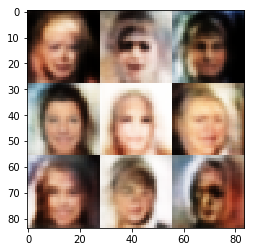

Epoch 1/2... Discriminator Loss: -1.3927... Generator Loss: 3.5794
Epoch 1/2... Discriminator Loss: -1.4319... Generator Loss: 4.7502
Epoch 1/2... Discriminator Loss: -1.9323... Generator Loss: 7.6093
Epoch 1/2... Discriminator Loss: -1.3382... Generator Loss: 3.1389
Epoch 1/2... Discriminator Loss: -1.4746... Generator Loss: 4.8672
Epoch 1/2... Discriminator Loss: -1.2760... Generator Loss: 5.1903
Epoch 1/2... Discriminator Loss: -1.4243... Generator Loss: 2.6534
Epoch 1/2... Discriminator Loss: -1.6976... Generator Loss: 5.5726
Epoch 1/2... Discriminator Loss: -1.4556... Generator Loss: 4.5661
Epoch 1/2... Discriminator Loss: -1.3674... Generator Loss: 2.8840


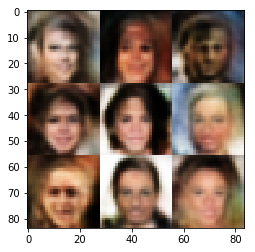

Epoch 1/2... Discriminator Loss: -1.2077... Generator Loss: 2.1290
Epoch 1/2... Discriminator Loss: -0.9657... Generator Loss: 4.7393
Epoch 1/2... Discriminator Loss: -1.3482... Generator Loss: 4.8572
Epoch 1/2... Discriminator Loss: -1.3380... Generator Loss: 4.0773
Epoch 1/2... Discriminator Loss: -1.5193... Generator Loss: 4.4674
Epoch 1/2... Discriminator Loss: -1.4256... Generator Loss: 4.7144
Epoch 1/2... Discriminator Loss: -1.4063... Generator Loss: 4.6742
Epoch 1/2... Discriminator Loss: -1.4322... Generator Loss: 5.6182
Epoch 2/2... Discriminator Loss: -1.4469... Generator Loss: 6.1029
Epoch 2/2... Discriminator Loss: -1.6802... Generator Loss: 6.0771


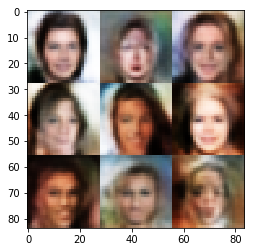

Epoch 2/2... Discriminator Loss: -1.6255... Generator Loss: 5.2866
Epoch 2/2... Discriminator Loss: -1.4843... Generator Loss: 4.1011
Epoch 2/2... Discriminator Loss: -1.3665... Generator Loss: 1.8068
Epoch 2/2... Discriminator Loss: -1.3546... Generator Loss: 3.2072
Epoch 2/2... Discriminator Loss: -1.1772... Generator Loss: 4.4101
Epoch 2/2... Discriminator Loss: -1.3588... Generator Loss: 2.8462
Epoch 2/2... Discriminator Loss: -1.5305... Generator Loss: 2.1826
Epoch 2/2... Discriminator Loss: -1.6124... Generator Loss: 5.2344
Epoch 2/2... Discriminator Loss: -1.5794... Generator Loss: 0.0656
Epoch 2/2... Discriminator Loss: -1.8395... Generator Loss: 2.4320


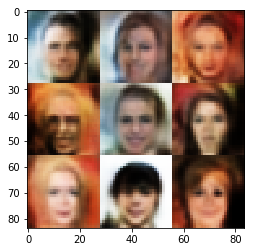

Epoch 2/2... Discriminator Loss: -1.4427... Generator Loss: 6.6063
Epoch 2/2... Discriminator Loss: -1.6577... Generator Loss: 5.4442
Epoch 2/2... Discriminator Loss: -1.6616... Generator Loss: 4.4143
Epoch 2/2... Discriminator Loss: -1.2452... Generator Loss: 4.2438
Epoch 2/2... Discriminator Loss: -1.5637... Generator Loss: 5.0870
Epoch 2/2... Discriminator Loss: -1.6816... Generator Loss: 4.8304
Epoch 2/2... Discriminator Loss: -1.2355... Generator Loss: 4.4858
Epoch 2/2... Discriminator Loss: -1.4135... Generator Loss: 5.7565
Epoch 2/2... Discriminator Loss: -1.3615... Generator Loss: 1.9838
Epoch 2/2... Discriminator Loss: -1.6730... Generator Loss: -0.9970


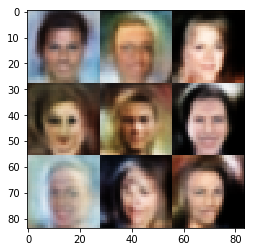

Epoch 2/2... Discriminator Loss: -1.5351... Generator Loss: 2.0388
Epoch 2/2... Discriminator Loss: -1.4956... Generator Loss: 3.6648
Epoch 2/2... Discriminator Loss: -1.3397... Generator Loss: 3.5185
Epoch 2/2... Discriminator Loss: -1.3020... Generator Loss: 3.8678
Epoch 2/2... Discriminator Loss: -1.1681... Generator Loss: 4.1154
Epoch 2/2... Discriminator Loss: -1.5407... Generator Loss: 6.0085
Epoch 2/2... Discriminator Loss: -1.3985... Generator Loss: 4.7767
Epoch 2/2... Discriminator Loss: -1.5446... Generator Loss: 1.6232
Epoch 2/2... Discriminator Loss: -1.3062... Generator Loss: 3.7885
Epoch 2/2... Discriminator Loss: -1.4111... Generator Loss: 7.5720


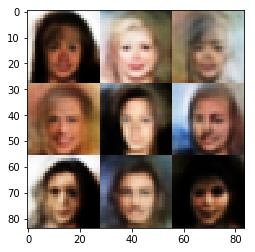

Epoch 2/2... Discriminator Loss: -1.2865... Generator Loss: 5.3269
Epoch 2/2... Discriminator Loss: -1.6246... Generator Loss: -1.0112
Epoch 2/2... Discriminator Loss: -1.4299... Generator Loss: 1.9097
Epoch 2/2... Discriminator Loss: -1.4628... Generator Loss: 7.5017
Epoch 2/2... Discriminator Loss: -1.2088... Generator Loss: 4.7933
Epoch 2/2... Discriminator Loss: -1.5425... Generator Loss: 4.4548
Epoch 2/2... Discriminator Loss: -1.6721... Generator Loss: 3.8867
Epoch 2/2... Discriminator Loss: -1.5857... Generator Loss: -0.5406
Epoch 2/2... Discriminator Loss: -1.7354... Generator Loss: 2.7636
Epoch 2/2... Discriminator Loss: -1.3783... Generator Loss: 2.7863


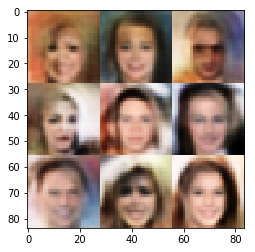

Epoch 2/2... Discriminator Loss: -1.3691... Generator Loss: 5.0357
Epoch 2/2... Discriminator Loss: -1.3148... Generator Loss: 3.1335
Epoch 2/2... Discriminator Loss: -1.6025... Generator Loss: 4.1782
Epoch 2/2... Discriminator Loss: -1.0894... Generator Loss: 2.9482
Epoch 2/2... Discriminator Loss: -1.5076... Generator Loss: 2.2982
Epoch 2/2... Discriminator Loss: -1.6121... Generator Loss: 1.4856
Epoch 2/2... Discriminator Loss: -1.7837... Generator Loss: -1.0326
Epoch 2/2... Discriminator Loss: -1.7629... Generator Loss: 2.2007
Epoch 2/2... Discriminator Loss: -1.0944... Generator Loss: 3.7849
Epoch 2/2... Discriminator Loss: -1.3173... Generator Loss: 4.9432


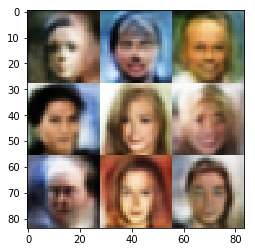

Epoch 2/2... Discriminator Loss: -1.7628... Generator Loss: 4.1839
Epoch 2/2... Discriminator Loss: -1.3763... Generator Loss: 6.5156
Epoch 2/2... Discriminator Loss: -1.2910... Generator Loss: 3.9171
Epoch 2/2... Discriminator Loss: -1.3576... Generator Loss: 5.0967
Epoch 2/2... Discriminator Loss: -1.6743... Generator Loss: 3.8685
Epoch 2/2... Discriminator Loss: -2.1049... Generator Loss: 7.1468
Epoch 2/2... Discriminator Loss: -1.3199... Generator Loss: 2.8152
Epoch 2/2... Discriminator Loss: -1.4353... Generator Loss: 2.9151
Epoch 2/2... Discriminator Loss: -1.3766... Generator Loss: 3.5594
Epoch 2/2... Discriminator Loss: -1.4124... Generator Loss: 0.8240


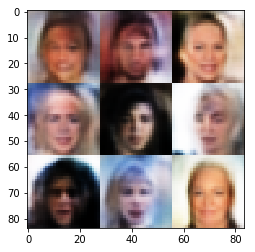

Epoch 2/2... Discriminator Loss: -1.6629... Generator Loss: 2.5431
Epoch 2/2... Discriminator Loss: -1.5571... Generator Loss: 1.4898
Epoch 2/2... Discriminator Loss: -1.2595... Generator Loss: 4.8351
Epoch 2/2... Discriminator Loss: -1.2768... Generator Loss: 4.4067
Epoch 2/2... Discriminator Loss: -1.8608... Generator Loss: 3.8800
Epoch 2/2... Discriminator Loss: -1.5617... Generator Loss: 3.0461
Epoch 2/2... Discriminator Loss: -1.5900... Generator Loss: 3.2417
Epoch 2/2... Discriminator Loss: -1.6555... Generator Loss: 3.3645
Epoch 2/2... Discriminator Loss: -1.3270... Generator Loss: 3.7214
Epoch 2/2... Discriminator Loss: -1.4479... Generator Loss: 1.7385


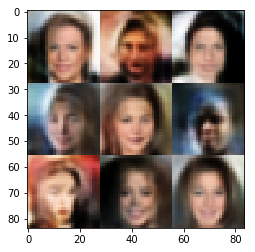

Epoch 2/2... Discriminator Loss: -1.2679... Generator Loss: -0.5732
Epoch 2/2... Discriminator Loss: -1.9093... Generator Loss: 3.9409
Epoch 2/2... Discriminator Loss: -1.7170... Generator Loss: 6.0066
Epoch 2/2... Discriminator Loss: -1.0231... Generator Loss: 0.9311
Epoch 2/2... Discriminator Loss: -1.3323... Generator Loss: 2.4522
Epoch 2/2... Discriminator Loss: -1.5162... Generator Loss: 4.4049
Epoch 2/2... Discriminator Loss: -1.4288... Generator Loss: 4.3331
Epoch 2/2... Discriminator Loss: -1.3768... Generator Loss: 3.9570
Epoch 2/2... Discriminator Loss: -1.4380... Generator Loss: 4.0572
Epoch 2/2... Discriminator Loss: -1.5950... Generator Loss: 2.4648


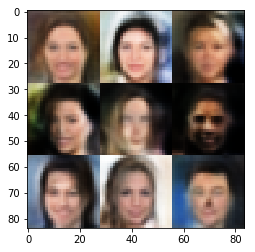

Epoch 2/2... Discriminator Loss: -1.5389... Generator Loss: 4.1118
Epoch 2/2... Discriminator Loss: -1.5774... Generator Loss: 1.8805
Epoch 2/2... Discriminator Loss: -1.5363... Generator Loss: 2.5467
Epoch 2/2... Discriminator Loss: -1.3309... Generator Loss: 2.6340
Epoch 2/2... Discriminator Loss: -1.4974... Generator Loss: 5.1257
Epoch 2/2... Discriminator Loss: -1.3478... Generator Loss: 4.2025
Epoch 2/2... Discriminator Loss: -1.3649... Generator Loss: 1.7545
Epoch 2/2... Discriminator Loss: -1.3819... Generator Loss: 3.0323
Epoch 2/2... Discriminator Loss: -1.3003... Generator Loss: 0.7139
Epoch 2/2... Discriminator Loss: -1.3200... Generator Loss: 3.5324


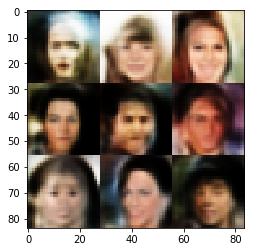

Epoch 2/2... Discriminator Loss: -1.3485... Generator Loss: 3.2522
Epoch 2/2... Discriminator Loss: -1.5832... Generator Loss: 3.2065
Epoch 2/2... Discriminator Loss: -1.3497... Generator Loss: 4.6596
Epoch 2/2... Discriminator Loss: -1.3067... Generator Loss: 3.6234
Epoch 2/2... Discriminator Loss: -1.4824... Generator Loss: 2.1547
Epoch 2/2... Discriminator Loss: -1.4157... Generator Loss: -1.7331
Epoch 2/2... Discriminator Loss: -1.5865... Generator Loss: -1.2543
Epoch 2/2... Discriminator Loss: -1.1184... Generator Loss: 1.8428
Epoch 2/2... Discriminator Loss: -1.5387... Generator Loss: 5.9384
Epoch 2/2... Discriminator Loss: -1.3810... Generator Loss: 7.2373


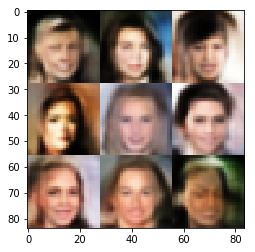

Epoch 2/2... Discriminator Loss: -1.0269... Generator Loss: 2.4841
Epoch 2/2... Discriminator Loss: -1.1802... Generator Loss: 3.8430
Epoch 2/2... Discriminator Loss: -1.1147... Generator Loss: 3.9953
Epoch 2/2... Discriminator Loss: -1.4067... Generator Loss: 5.1482
Epoch 2/2... Discriminator Loss: -1.3187... Generator Loss: 7.3018
Epoch 2/2... Discriminator Loss: -1.4792... Generator Loss: 5.9136
Epoch 2/2... Discriminator Loss: -1.7851... Generator Loss: 6.2547
Epoch 2/2... Discriminator Loss: -1.5799... Generator Loss: 9.1062
Epoch 2/2... Discriminator Loss: -1.3561... Generator Loss: 6.5270
Epoch 2/2... Discriminator Loss: -1.4737... Generator Loss: 5.0104


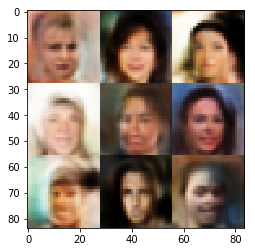

Epoch 2/2... Discriminator Loss: -1.2434... Generator Loss: 4.2251
Epoch 2/2... Discriminator Loss: -1.4826... Generator Loss: 3.3540
Epoch 2/2... Discriminator Loss: -1.2338... Generator Loss: 2.3317
Epoch 2/2... Discriminator Loss: -1.4846... Generator Loss: 4.1626
Epoch 2/2... Discriminator Loss: -1.5580... Generator Loss: 3.3542
Epoch 2/2... Discriminator Loss: -1.3385... Generator Loss: 0.2180
Epoch 2/2... Discriminator Loss: -1.3233... Generator Loss: 0.4018
Epoch 2/2... Discriminator Loss: -1.3107... Generator Loss: 1.5799
Epoch 2/2... Discriminator Loss: -1.4967... Generator Loss: 0.8136
Epoch 2/2... Discriminator Loss: -1.4557... Generator Loss: 0.4935


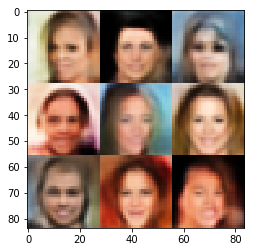

Epoch 2/2... Discriminator Loss: -1.5475... Generator Loss: 1.7727
Epoch 2/2... Discriminator Loss: -1.4658... Generator Loss: 2.2783
Epoch 2/2... Discriminator Loss: -1.4474... Generator Loss: 2.5619
Epoch 2/2... Discriminator Loss: -1.3517... Generator Loss: 2.4611
Epoch 2/2... Discriminator Loss: -1.5485... Generator Loss: 5.7422
Epoch 2/2... Discriminator Loss: -1.5466... Generator Loss: 2.6922
Epoch 2/2... Discriminator Loss: -1.4607... Generator Loss: 4.3562
Epoch 2/2... Discriminator Loss: -1.3159... Generator Loss: 1.7893
Epoch 2/2... Discriminator Loss: -1.4618... Generator Loss: 2.5033
Epoch 2/2... Discriminator Loss: -1.2950... Generator Loss: 3.7751


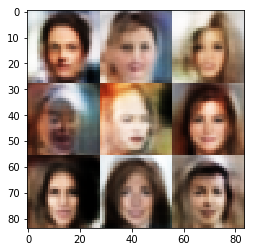

Epoch 2/2... Discriminator Loss: -1.2867... Generator Loss: 1.3801
Epoch 2/2... Discriminator Loss: -1.3551... Generator Loss: 2.5547
Epoch 2/2... Discriminator Loss: -1.5213... Generator Loss: 2.1834
Epoch 2/2... Discriminator Loss: -1.5445... Generator Loss: 1.2042
Epoch 2/2... Discriminator Loss: -1.5664... Generator Loss: 0.2321
Epoch 2/2... Discriminator Loss: -1.3070... Generator Loss: 2.4076
Epoch 2/2... Discriminator Loss: -1.3944... Generator Loss: 2.1548
Epoch 2/2... Discriminator Loss: -1.4680... Generator Loss: 3.6002
Epoch 2/2... Discriminator Loss: -1.4808... Generator Loss: 5.6913
Epoch 2/2... Discriminator Loss: -1.3417... Generator Loss: 1.8229


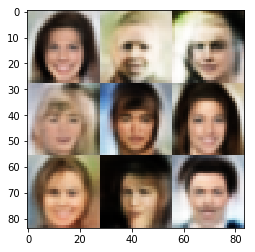

Epoch 2/2... Discriminator Loss: -1.4208... Generator Loss: 2.1976
Epoch 2/2... Discriminator Loss: -1.6004... Generator Loss: 1.6042
Epoch 2/2... Discriminator Loss: -1.4546... Generator Loss: -0.7006
Epoch 2/2... Discriminator Loss: -1.5279... Generator Loss: -1.0909
Epoch 2/2... Discriminator Loss: -1.3685... Generator Loss: 4.2556
Epoch 2/2... Discriminator Loss: -1.5267... Generator Loss: 4.3654
Epoch 2/2... Discriminator Loss: -1.4320... Generator Loss: 6.6451
Epoch 2/2... Discriminator Loss: -0.9997... Generator Loss: 2.3929
Epoch 2/2... Discriminator Loss: -1.4641... Generator Loss: 2.9614
Epoch 2/2... Discriminator Loss: -1.2702... Generator Loss: 2.6418


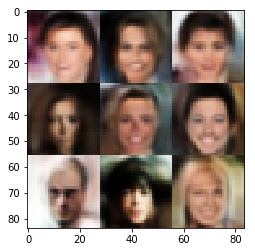

Epoch 2/2... Discriminator Loss: -1.2983... Generator Loss: 4.4187
Epoch 2/2... Discriminator Loss: -1.4397... Generator Loss: 1.6770
Epoch 2/2... Discriminator Loss: -1.7326... Generator Loss: 7.3924
Epoch 2/2... Discriminator Loss: -1.2466... Generator Loss: 9.0591
Epoch 2/2... Discriminator Loss: -1.3656... Generator Loss: 0.8160
Epoch 2/2... Discriminator Loss: -1.2692... Generator Loss: 0.7507


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5
print_every = 10
show_every= 100

epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.